# MorphCT

goal: 
 - atomistic gsd snapshot -> 
 - assign chromophores -> 
 - do QCC calcs -> 
 - run KMC -> 
 - calculate mobility

current schema:
 - xml file
 - chromphore params set in par.py
 - if starting with atomistic, we can skip fine graining and molecular dynamics and only run:
     - execute_obtain_chromophores = False                                             
     - execute_ZINDO = False                                                           
     - execute_calculate_transfer_integrals = False                                    
     - execute_calculate_mobility = False    

In [1]:
from collections import defaultdict
import itertools
import os
import pickle
import multiprocessing as mp

import ele
import freud
import gsd.hoomd
import mbuild as mb
import numpy as np
from openbabel import openbabel
from openbabel import pybel
import pyscf
from pyscf.semiempirical import MINDO3

from morphct.code import obtain_chromophores as oc
from morphct import transfer_integrals as ti
from morphct import execute_qcc as eqcc
from morphct import mobility_kmc as kmc
from morphct import chromophores

/Users/jenny/miniconda3/envs/morphct-dev/lib/python3.8/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  from numpy import (exp, inf, pi, sqrt, floor, sin, cos, around, int,
/Users/jenny/miniconda3/envs/morphct-dev/lib/python3.8/site-packages/scipy/special/orthogonal.py:81: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` o

In [2]:
def visualize_qcc_input(qcc_input):
    comp = mb.Compound()
    for line in qcc_input.split(";")[:-1]:
        atom, x, y, z = line.split()
        xyz = np.array([x,y,z], dtype=float)
        # Angstrom -> nm
        xyz /= 10
        comp.add(mb.Particle(name=atom,pos=xyz))
    comp.visualize().show()

OK, so I'm looking around for an xml file in the "obtain chromophores" tests but all I can find are these pickle files. I want to view them before I continue. ovito and vmd no longer support xmls... gah --> using mbuild.

In [3]:
path = "tests/assets/donor_polymer/OC/donor_polymer_post_obtain_chromophores.pickle"
(
    AA_morphdict, 
    CG_morphdict, 
    CGtoAAID_list, 
    param_dict, 
    chromo_list_old
) = pickle.load(open(path,"rb"))

In [4]:
all_types = list(set(AA_morphdict['type']))
bond_array = np.array([(i,j) for name,i,j in AA_morphdict["bond"]])

snap = gsd.hoomd.Snapshot()
snap.configuration.box = np.array([
    AA_morphdict["lx"],
    AA_morphdict["ly"],
    AA_morphdict["lz"],
    AA_morphdict["xy"],
    AA_morphdict["xz"],
    AA_morphdict["yz"]
])
snap.configuration.dimensions = AA_morphdict["dimensions"]
snap.particles.N = AA_morphdict["natoms"]
snap.particles.body = AA_morphdict["body"]
snap.particles.position = AA_morphdict["position"]
snap.particles.charge = AA_morphdict["charge"]
snap.particles.diameter = AA_morphdict["diameter"]
snap.particles.mass = AA_morphdict["mass"]
snap.particles.image = AA_morphdict["image"]
snap.particles.types = all_types
snap.particles.typeid = [all_types.index(i) for i in AA_morphdict["type"]]
snap.bonds.N = len(bond_array)
snap.bonds.group = bond_array
snap.validate()

In [5]:
box = snap.configuration.box[:3]
unwrapped_positions = snap.particles.position + snap.particles.image * box

In [6]:
# Run this if you want to confirm that the unwrapped positions are correct in OVITO
#with gsd.hoomd.open(name='test.gsd', mode='wb') as f:
#    f.append(snap)
#    snap.particles.position = unwrapped_positions
#    f.append(snap)

In [7]:
conversion_dict = {
    "S1": ele.element_from_symbol("S"), 
    "H1": ele.element_from_symbol("H"), 
    "C5": ele.element_from_symbol("C"), 
    "C1": ele.element_from_symbol("C"), 
    "C4": ele.element_from_symbol("C"), 
    "C6": ele.element_from_symbol("C"), 
    "C8": ele.element_from_symbol("C"), 
    "C9": ele.element_from_symbol("C"), 
    "C3": ele.element_from_symbol("C"), 
    "C7": ele.element_from_symbol("C"), 
    "C2": ele.element_from_symbol("C"),
    "C10": ele.element_from_symbol("C"),
}

amber_dict = {
    "c":  ele.element_from_symbol("C"),
    "c1": ele.element_from_symbol("C"),
    "c2": ele.element_from_symbol("C"),
    "c3": ele.element_from_symbol("C"),
    "ca": ele.element_from_symbol("C"),
    "cp": ele.element_from_symbol("C"),
    "cq": ele.element_from_symbol("C"),
    "cc": ele.element_from_symbol("C"),
    "cd": ele.element_from_symbol("C"),
    "ce": ele.element_from_symbol("C"),
    "cf": ele.element_from_symbol("C"),
    "cg": ele.element_from_symbol("C"),
    "ch": ele.element_from_symbol("C"),
    "cx": ele.element_from_symbol("C"),
    "cy": ele.element_from_symbol("C"),
    "cu": ele.element_from_symbol("C"),
    "cv": ele.element_from_symbol("C"),
    "h1": ele.element_from_symbol("H"),
    "h2": ele.element_from_symbol("H"),
    "h3": ele.element_from_symbol("H"),
    "h4": ele.element_from_symbol("H"),
    "h5": ele.element_from_symbol("H"),
    "ha": ele.element_from_symbol("H"),
    "hc": ele.element_from_symbol("H"),
    "hn": ele.element_from_symbol("H"),
    "ho": ele.element_from_symbol("H"),
    "hp": ele.element_from_symbol("H"),
    "hs": ele.element_from_symbol("H"),
    "hw": ele.element_from_symbol("H"),
    "hx": ele.element_from_symbol("H"),
    "f":  ele.element_from_symbol("F"),
    "cl": ele.element_from_symbol("Cl"),
    "br": ele.element_from_symbol("Br"),
    "i":  ele.element_from_symbol("I"),
    "n":  ele.element_from_symbol("N"),
    "n1": ele.element_from_symbol("N"),
    "n2": ele.element_from_symbol("N"),
    "n3": ele.element_from_symbol("N"),
    "n4": ele.element_from_symbol("N"),
    "na": ele.element_from_symbol("N"),
    "nb": ele.element_from_symbol("N"),
    "nc": ele.element_from_symbol("N"),
    "nd": ele.element_from_symbol("N"),
    "ne": ele.element_from_symbol("N"),
    "nf": ele.element_from_symbol("N"),
    "nh": ele.element_from_symbol("N"),
    "no": ele.element_from_symbol("N"),
    "o":  ele.element_from_symbol("O"),
    "oh": ele.element_from_symbol("O"),
    "os": ele.element_from_symbol("O"),
    "ow": ele.element_from_symbol("O"),
    "p2": ele.element_from_symbol("P"),
    "p3": ele.element_from_symbol("P"),
    "p4": ele.element_from_symbol("P"),
    "p5": ele.element_from_symbol("P"),
    "pb": ele.element_from_symbol("P"),
    "pc": ele.element_from_symbol("P"),
    "pd": ele.element_from_symbol("P"),
    "pe": ele.element_from_symbol("P"),
    "pf": ele.element_from_symbol("P"),
    "px": ele.element_from_symbol("P"),
    "py": ele.element_from_symbol("P"),
    "s":  ele.element_from_symbol("S"),
    "s2": ele.element_from_symbol("S"),
    "s4": ele.element_from_symbol("S"),
    "s6": ele.element_from_symbol("S"),
    "sh": ele.element_from_symbol("S"),
    "ss": ele.element_from_symbol("S"),
    "sx": ele.element_from_symbol("S"),
    "sy": ele.element_from_symbol("S"),
}

In [8]:
smarts_str = "c1cscc1CCCCCC"

In [9]:
aaids = chromophores.get_chromo_ids_smiles(snap, smarts_str, conversion_dict)

In [10]:
chromo_list = []
for i,aaid in enumerate(aaids):
    chromo_list.append(chromophores.Chromophore(i, snap, aaid, "donor", conversion_dict))

Next let's get the neighbors

In [11]:
qcc_pairs = chromophores.set_neighbors_voronoi(
    chromo_list, snap, conversion_dict, d_cut=min(box)/2
)
print(len(qcc_pairs))

135


In [12]:
# Checked and all pairs look reasonable!
#i = 13
#visualize_qcc_input(qcc_pairs[i][1])

next need to run ZINDO

`eqcc.get_homolumo(chromo_list[0].qcc_input)` returns HOMO-1, HOMO, LUMO, LUMO+1

`eqcc.singles_homolumo` does for all chromophores

In [13]:
outpath = os.path.join(os.getcwd(), "notebook_output")
s_filename = os.path.join(outpath, "singles_energies.txt")
print(s_filename)

/Users/jenny/Projects/morphct/notebook_output/singles_energies.txt


In [14]:
#%%time
#data = eqcc.singles_homolumo(chromo_list, s_filename)
#
#CPU times: user 26.1 ms, sys: 42.2 ms, total: 68.3 ms
#Wall time: 3.36 s

This gets the energy values of the chromophores using the single inputs and writes them to a file. No energy values are set:

In [15]:
chromo = chromo_list[0]
print(chromo.homo)
print(len(chromo.neighbors), len(chromo.neighbors_delta_e))
print(chromo.neighbors_delta_e[0])

None
10 10
None


Next compute the pair energies:

In [16]:
d_filename = os.path.join(outpath, "dimer_energies.txt")
print(d_filename)

/Users/jenny/Projects/morphct/notebook_output/dimer_energies.txt


In [17]:
#%%time
#dimer_data = eqcc.dimer_homolumo(qcc_pairs, d_filename)
#
#CPU times: user 22.5 ms, sys: 31.9 ms, total: 54.4 ms
#Wall time: 31.9 s

In [18]:
data = eqcc.get_singlesdata(s_filename)
print(data[0])
dimer_data = eqcc.get_dimerdata(d_filename)
print(dimer_data[0])

[-9.01337182 -8.5404688   0.17193304  0.86523495]
((0, 1), (-8.709172080560524, -8.217563821747918, -0.2643404153714356, 0.35184321402966473))


In [19]:
eqcc.set_energyvalues(chromo_list, s_filename, d_filename)

In [20]:
print(chromo.homo)
print(len(chromo.neighbors), len(chromo.neighbors_delta_e))
print(chromo.neighbors_delta_e[0])

-8.540468797580658
10 10
-0.016112646652969076


OK, I think I should be ready to run KMC. Before it'll work we need to add some things to the param dict and change some paths.

```
notebook_outputs/KMC/ 
```

run_kmc : single_core_run_mob_KMC

kmc : mobility_KMC

In [21]:
seed = param_dict['random_seed_override']

In [22]:
jobs_list = kmc.get_jobslist([1.00e-13, 1.00e-12], n_holes=10, seed=seed)

In [23]:
KMC_directory = os.path.join(outpath, "KMC")

Multiprocessing gives a reasonable speedup! (see below)

In [24]:
#%%time
#
#box = snap.configuration.box[:3]
#temp = 300
#
#running_jobs = []
#pipes = []
#
#for jobs in jobs_list:
#    child_seed = np.random.randint(0, 2 ** 32)                              
#                                                                            
#    recv_end, send_end = mp.Pipe(False)                                     
#    p = mp.Process(                                                         
#            target=kmc.run_single_kmc,                                          
#            args=(                                                          
#                jobs,                                                       
#                KMC_directory,                                              
#                chromo_list,                                                
#                box,                                                        
#                temp,                                                     
#                ),                                                          
#            kwargs={                                                                                                                       
#                "seed": child_seed,                                         
#                "send_end": send_end,                                                                             
#                }                                                           
#            )                                                               
#    running_jobs.append(p) 
#    pipes.append(recv_end)                                                  
#    p.start()
#    
#for p in running_jobs:                                                      
#    p.join()                                                                
#
#carrier_data_list = [x.recv() for x in pipes]  
#
#CPU times: user 13.3 ms, sys: 20.9 ms, total: 34.1 ms
#Wall time: 1.67 s

#%%time
#
#box = snap.configuration.box[:3]
#temp = 300
#
#carrier_data_list = []
#
#for jobs in jobs_list: 
#    child_seed = np.random.randint(0, 2 ** 32) 
#    data = kmc.run_single_kmc(
#        jobs,                                                       
#        KMC_directory,                                              
#        chromo_list,                                                
#        box,                                                        
#        temp,                                                                                                                                                                        
#        seed= child_seed
#    )                                                             
#
#    carrier_data_list.append(data)

#CPU times: user 3.67 s, sys: 535 ms, total: 4.21 s
#Wall time: 4.02 s

# for next time
- make vprint loggable based on cpu_rank √
- work on combined_data - get centers √
- finish kmc_analyze - got to line 2477

In [25]:
combined_data = kmc.run_kmc(
    jobs_list, KMC_directory, chromo_list, snap, 300, verbose=1
)

All KMC jobs completed!
Combining outputs...


In [41]:
chromoi = chromo_list[0]
chromoj = chromo_list[chromoi.neighbors[0][0]]
print(chromoi,chromoj)

Chromophore 0 (donor): 11 atoms at 8.532 -27.966 -35.075 Chromophore 1 (donor): 11 atoms at 15.695 -26.423 -29.522


In [46]:
i = 0
j = 1
relative_image = [img for ind,img in chromoi.neighbors if ind == j][0]
print(relative_image)
chromoi.neighbors[0] = [1,"heck"]

heck


In [53]:
for i,pos in enumerate(combined_data["current_position"][:1000]):
    image = combined_data["image"][i]
    position = image * box + pos
    if not np.array_equal(pos, position):
        print(i)
        print(position,pos)
    

17
[-51.30532664 -49.81538062  -3.18907363] [33.88430197 35.37424798 -3.18907363]


In [ ]:
np.max

In [80]:
dims = np.array([(-i/2, i/2) for i in box/10])
list(itertools.product(range(2),repeat=3))
#corners = [dims]
corners = [(dims[0,i],dims[1,j],dims[2,k]) for i,j,k in itertools.product(range(2),repeat=3)]
corners

[(-4.259481430053711, -4.259481430053711, -4.259481430053711),
 (-4.259481430053711, -4.259481430053711, 4.259481430053711),
 (-4.259481430053711, 4.259481430053711, -4.259481430053711),
 (-4.259481430053711, 4.259481430053711, 4.259481430053711),
 (4.259481430053711, -4.259481430053711, -4.259481430053711),
 (4.259481430053711, -4.259481430053711, 4.259481430053711),
 (4.259481430053711, 4.259481430053711, -4.259481430053711),
 (4.259481430053711, 4.259481430053711, 4.259481430053711)]

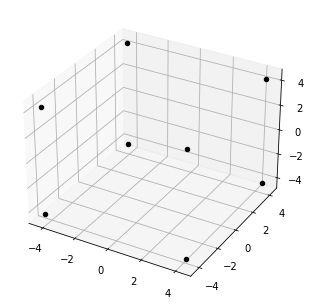

In [92]:
import mpl_toolkits.mplot3d as p3
import matplotlib.pyplot as plt

fig = plt.gcf()
ax = p3.Axes3D(fig)  
for i in corners:
    ax.scatter(*i, c="k", linewidth=1)

help(ax.scatter)

In [26]:
print(*[key for key in combined_data.keys()], sep="\n")

id
image
initial_position
current_position
lambda_ij
hop_limit
temp
lifetime
current_time
hole_history
electron_history
c_type
n_hops
box
displacement
mol_id_dict
use_average_hop_rates
average_intra_hop_rate
average_inter_hop_rate
use_koopmans
boltz_penalty
use_VRH
hopping_prefactor


In [27]:

hole_inds = np.where(np.array(combined_data["c_type"]) == "hole")
elec_inds = np.where(np.array(combined_data["c_type"]) == "electron")
hole_data = {}                                                              
elec_data = {}                                                              
for key, val in combined_data.items():                                      
    hole_data[key] = [val[i] for i in hole_inds[0]]
    elec_data[key] = [val[i] for i in elec_inds[0]]
#hole_data, elec_data


In [28]:
heck = defaultdict(list)
heck[0] += [0]
heck[1e5] += "a"
for k,v in heck.items():
    print(k,v)
    print(type(k),type(v))

0 [0]
<class 'int'> <class 'list'>
100000.0 ['a']
<class 'float'> <class 'list'>


In [31]:
mylist = [None, None, None, "realvalue"]
if np.any([i is not None for i in mylist]):
    print("heck")

heck


In [29]:
if hole_data["id"]:
    print("heck hole")
if elec_data["id"]:
    print("heck elec")
hole,elec = False, False
print(hole)

heck hole
False


In [39]:
carrier_history = sum(combined_data["hole_history"])
carrier_history, combined_data["hole_history"][0]

(<24x24 sparse matrix of type '<class 'numpy.longlong'>'
 	with 32 stored elements in Compressed Sparse Row format>,
 <24x24 sparse matrix of type '<class 'numpy.int64'>'
 	with 10 stored elements in List of Lists format>)

In [45]:
for i,j in nonzero:
    print(i,j)

0 1
1 0
1 2
2 1
2 3
3 2
3 4
4 3
5 6
6 5
6 7
7 6
7 8
8 7
8 9
9 8
9 10
10 9
10 11
11 10
11 12
12 11
14 15
15 14
15 16
16 15
16 17
17 16
18 19
19 20
20 7
20 19


In [44]:
nonzero = list(zip(*carrier_history.nonzero()))
nonzero

[(0, 1),
 (1, 0),
 (1, 2),
 (2, 1),
 (2, 3),
 (3, 2),
 (3, 4),
 (4, 3),
 (5, 6),
 (6, 5),
 (6, 7),
 (7, 6),
 (7, 8),
 (8, 7),
 (8, 9),
 (9, 8),
 (9, 10),
 (10, 9),
 (10, 11),
 (11, 10),
 (11, 12),
 (12, 11),
 (14, 15),
 (15, 14),
 (15, 16),
 (16, 15),
 (16, 17),
 (17, 16),
 (18, 19),
 (19, 20),
 (20, 7),
 (20, 19)]

# OUTDATED PAST HERE

In [31]:
from morphct.utils import kmc_analyze

IndentationError: unexpected indent (kmc_analyze.py, line 2612)

In [30]:
kmc_analyze.main(
    AA_morphdict, 
    CG_morphdict, 
    CGtoAAID_list, 
    param_dict,                                                             
    chromo_list,                                                            
    [combined_data],                                                      
    KMC_directory
)

NameError: name 'kmc_analyze' is not defined